In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict

In [2]:
# Define colors for consistency
COLORS = {
    'Random': '#ff7f0e',  # Orange
    'Random Walk': '#1f77b4',  # Blue
    'Greedy': '#2ca02c',  # Green
    'Steepest': '#d62728',  # Red
    'Heuristic': '#9467bd'   # Purple
}

In [13]:
def clean_solution(solution_str):
    solution = solution_str.strip('[]').split()
    return [int(x) for x in solution]

csv_path= "results/results_2025-04-03T09_23.csv"  # Change this to your CSV path
df = pd.read_csv(csv_path)
df["Solution"] = df["Solution"].apply(clean_solution)
df.head()

,Instance,Solver,Run,InitialFitness,FinalFitness,TimeMs,Steps,Evaluations,SolutionsChecked,Solution
0,chr12b.dat,Steepest,1,43194,16616,0.0,10,660,660,"[5, 10, 8, 11, 9, 3, 1, 6, 2, 7, 0, 4]"
1,chr12b.dat,Steepest,2,46854,9742,0.0,9,594,594,"[4, 6, 0, 9, 10, 2, 3, 1, 8, 5, 11, 7]"
2,chr12b.dat,Steepest,3,52064,15398,0.0,9,594,594,"[9, 7, 5, 1, 6, 0, 10, 3, 2, 4, 11, 8]"
3,chr12b.dat,Steepest,4,49026,15384,0.0,10,660,660,"[6, 4, 10, 9, 3, 0, 7, 11, 8, 5, 1, 2]"
4,chr12b.dat,Steepest,5,41224,20452,0.0,10,660,660,"[8, 11, 10, 3, 6, 1, 5, 7, 2, 4, 9, 0]"


In [7]:
def load_optimal_solution(instance_name):
    base_name = os.path.splitext(instance_name)[0]
    sln_path = f"instances/{base_name}.sln"

    try:
        with open(sln_path, 'r') as f:
            lines = f.readlines()
            _, optimal_fitness = map(int, lines[0].strip().split())
            optimal_solution = []
            for line in lines[1:]:
                optimal_solution.extend(map(int, line.strip().split()))
            return optimal_fitness, optimal_solution
    except:
        return None

instances = df['Instance'].unique()
best_solution_fitness = {}
best_solutions = {}

for instance in instances:
    result = load_optimal_solution(instance)
    if result:
        best_solution_fitness[instance], best_solutions[instance] = result


In [8]:
def load_optimal_solution(instance_name):
    base_name = os.path.splitext(instance_name)[0]
    sln_path = f"instances/{base_name}.sln"

    try:
        with open(sln_path, 'r') as f:
            lines = f.readlines()
            _, optimal_fitness = map(int, lines[0].strip().split())
            optimal_solution = []
            for line in lines[1:]:
                optimal_solution.extend(map(int, line.strip().split()))
            return optimal_fitness, optimal_solution
    except:
        return None

instances = df['Instance'].unique()
best_solution_fitness = {}
best_solutions = {}

for instance in instances:
    result = load_optimal_solution(instance)
    if result:
        best_solution_fitness[instance], best_solutions[instance] = result

In [9]:
df['GapToBest'] = df.apply(lambda row: 
    (row['FinalFitness'] - best_solution_fitness.get(row['Instance'], row['FinalFitness'])) / 
    best_solution_fitness.get(row['Instance'], row['FinalFitness']) * 100, axis=1)

df['ImprovementPercent'] = ((df['InitialFitness'] - df['FinalFitness']) / df['InitialFitness']) * 100
df['EvalsPerSecond'] = df['Evaluations'] / ((df['TimeMs'] / 1000) + 1e-9)
df['Efficiency'] = df['EvalsPerSecond'] / (df['FinalFitness'] + 1e-9)
df.head()

,Instance,Solver,Run,InitialFitness,FinalFitness,TimeMs,Steps,Evaluations,SolutionsChecked,Solution,GapToBest,ImprovementPercent,EvalsPerSecond,Efficiency
0,chr12b.dat,Steepest,1,43194,16616,0.0,10,660,660,"[5, 10, 8, 11, 9, 3, 1, 6, 2, 7, 0, 4]",70.560460,61.531694,6.600000e+11,3.972075e+07
1,chr12b.dat,Steepest,2,46854,9742,0.0,9,594,594,"[4, 6, 0, 9, 10, 2, 3, 1, 8, 5, 11, 7]",0.000000,79.207752,5.940000e+11,6.097311e+07
2,chr12b.dat,Steepest,3,52064,15398,0.0,9,594,594,"[9, 7, 5, 1, 6, 0, 10, 3, 2, 4, 11, 8]",58.057894,70.424862,5.940000e+11,3.857644e+07
3,chr12b.dat,Steepest,4,49026,15384,0.0,10,660,660,"[6, 4, 10, 9, 3, 0, 7, 11, 8, 5, 1, 2]",57.914186,68.620732,6.600000e+11,4.290172e+07
4,chr12b.dat,Steepest,5,41224,20452,0.0,10,660,660,"[8, 11, 10, 3, 6, 1, 5, 7, 2, 4, 9, 0]",109.936358,50.388123,6.600000e+11,3.227068e+07


In [12]:
def analyze_qap_results(df):
    instances = df['Instance'].unique()
    
    best_solution_fitness = {}
    best_solutions = {}
    
    for instance in instances:
        best_solution_fitness[instance], best_solutions[instance] = load_optimal_solution(instance)

    # Add gap to best known solution
    df['GapToBest'] = df.apply(lambda row: (row['FinalFitness'] - best_solution_fitness[row['Instance']]) / best_solution_fitness[row['Instance']] * 100, axis=1)
    
    # Add improvement percentage
    df['ImprovementPercent'] = ((df['InitialFitness'] - df['FinalFitness']) / df['InitialFitness'] * 100)
    
    # Add evaluations per second
    df['EvalsPerSecond'] = df['Evaluations'] / ((df['TimeMs'] / 1000) + 1e-9)
    
    return df

def plot_gap_to_best(df, output_dir):
    plt.figure(figsize=(14, 8))

    # Order instances by mean GapToBest
    instance_order = df.groupby("Instance")["GapToBest"].mean().sort_values().index
    df["Instance"] = pd.Categorical(df["Instance"], categories=instance_order, ordered=True)
    instances = list(instance_order)

    # Calculate mean gap by instance and solver
    gap_data = df.groupby(['Instance', 'Solver'])['GapToBest'].mean().reset_index()
    solvers = df['Solver'].unique()

    for solver in solvers:
        y_vals = []
        for instance in instances:
            filtered = gap_data[(gap_data["Instance"] == instance) & (gap_data["Solver"] == solver)]
            if not filtered.empty:
                value = filtered["GapToBest"].values[0]
                y_vals.append(value if value>0 else value + 1e-2)
            else:
                y_vals.append(np.nan)

        x = np.arange(len(instances))
        plt.scatter(x, y_vals, label=solver, color=COLORS[solver])
        plt.plot(x, y_vals, linestyle='--', color=COLORS[solver])

    plt.xlabel('Instance')
    plt.ylabel('Gap to Best Known Solution (%)')
    plt.title('Average Gap to Best Known Solution by Solver and Instance')
    plt.xticks(np.arange(len(instances)), instances, rotation=45)
    plt.yscale("log") 
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'gap_to_best.png'), dpi=300)
    plt.close()

def plot_initial_vs_final(df, output_dir):
    instances = df['Instance'].unique()
    
    for instance in instances:
        plt.figure(figsize=(10, 8))
        instance_df = df[df['Instance'] == instance]
        
        for solver in df['Solver'].unique():
            solver_df = instance_df[instance_df['Solver'] == solver]
            plt.scatter(solver_df['InitialFitness'], solver_df['FinalFitness'], 
                       label=solver, alpha=0.7, color=COLORS[solver])
            
        plt.xlabel('Initial Fitness')
        plt.ylabel('Final Fitness')
        plt.title(f'Initial vs Final Fitness for {instance}')
        plt.legend()
        # Add a diagonal line for reference (no improvement line)
        max_val = max(instance_df['InitialFitness'].max(), instance_df['FinalFitness'].max())
        min_val = min(instance_df['InitialFitness'].min(), instance_df['FinalFitness'].min())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'initial_vs_final_{instance}.png'), dpi=300)
        plt.close()
    
    # Create one combined plot with normalized values for comparison
    plt.figure(figsize=(12, 10))
    
    added_solvers = set()
    for instance in instances:
        instance_df = df[df['Instance'] == instance]
        
        # Normalize values for this instance
        min_initial = instance_df['InitialFitness'].min()
        max_initial = instance_df['InitialFitness'].max()
        min_final = instance_df['FinalFitness'].min()
        max_final = instance_df['FinalFitness'].max()
        
        for solver in df['Solver'].unique():
            solver_df = instance_df[instance_df['Solver'] == solver]
            
            x_norm = (solver_df['InitialFitness'] - min_initial) / (max_initial - min_initial) if max_initial > min_initial else solver_df['InitialFitness'] / max_initial
            y_norm = (solver_df['FinalFitness'] - min_final) / (max_final - min_final) if max_final > min_final else solver_df['FinalFitness'] / max_final
            if solver not in added_solvers:
                plt.scatter(
                    x_norm, 
                    y_norm, 
                    alpha=0.7, 
                    label=solver,
                    color=COLORS[solver],
                )
                added_solvers.add(solver)
            else:
                plt.scatter(
                    x_norm, 
                    y_norm, 
                    alpha=0.7, 
                    color=COLORS[solver],
                )
    
    plt.xlabel('Normalized Initial Fitness')
    plt.ylabel('Normalized Final Fitness')
    plt.title('Initial vs Final Fitness (Normalized) Across All Instances')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'initial_vs_final_normalized.png'), dpi=300)
    plt.close()

def plot_time_efficiency(df, output_dir):
    plt.figure(figsize=(14, 8))

    df['Efficiency'] = df['EvalsPerSecond'] / (df['FinalFitness'] + 1e-9)
    instances = df['Instance'].unique()
    solvers = df['Solver'].unique()
    width = 5 / len(solvers)

    metrics = {
        "evaluations_per_second.png": "EvalsPerSecond",
        "evaluations_count.png": "Evaluations",
        "execution_time.png": "TimeMs",
        "best_final.png": "FinalFitness",
        "efficiency.png": "Efficiency"
    }

    titles = {
        "evaluations_per_second.png": "Algorithm Efficiency: Evaluations per Second",
        "evaluations_count.png": "Number of Function Evaluations by Instance and Solver",
        "execution_time.png": "Execution Time by Instance and Solver",
        "best_final.png": "Best Final Fitness by Instance and Solver",
        "efficiency.png": "Overall Efficiency by Instance and Solver"
    }

    y_labels = {
        "evaluations_per_second.png": "Evaluations per Second",
        "evaluations_count.png": "Number of Evaluations",
        "execution_time.png": "Time (ms)",
        "best_final.png": "Fitness",
        "efficiency.png": "Efficiency (EvalsPerSecond / FinalFitness)"
    }

    for filename, metric in metrics.items():
        plt.figure(figsize=(14, 8))

        for solver in solvers:
            y_vals = []
            for instance in instances:
                filtered = df[(df["Solver"] == solver) & (df["Instance"] == instance)]
                if not filtered.empty:
                    value = filtered[metric].mean()
                    y_vals.append(value + 1e-2)
                else:
                    y_vals.append(0)


            x = np.arange(len(instances))
            plt.scatter(x, y_vals, label=solver, color=COLORS[solver])
            plt.plot(x, y_vals, linestyle='--', color=COLORS[solver])

        plt.xlabel('Instance')
        plt.ylabel(y_labels[filename])
        plt.title(titles[filename])
        plt.xticks(np.arange(len(instances)), instances, rotation=45)
        plt.yscale('log')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, filename), dpi=300)
        plt.close()
        

def plot_improvement_distribution(df, output_dir):
    plt.figure(figsize=(12, 8))
    
    for solver in df['Solver'].unique():
        solver_data = df[df['Solver'] == solver]
        sns.kdeplot(solver_data['ImprovementPercent'], label=solver, fill=True, color=COLORS[solver], alpha=0.5)
    
    plt.xlabel('Improvement Percentage')
    plt.ylabel('Density')
    plt.xlim(left=0)
    plt.title('Distribution of Improvement Percentage by Solver')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'improvement_distribution.png'), dpi=300)
    plt.close()
    
    # Now plot improvement by instance
    plt.figure(figsize=(14, 8))
    
    # Group by instance and solver
    imp_data = df.groupby(['Instance', 'Solver'])['ImprovementPercent'].mean().reset_index()
    
    # For each solver, create a set of bars
    instances = df['Instance'].unique()
    solvers = df['Solver'].unique()
    width = 5 / len(solvers)
    offset = 0
    
    for instance in sorted(instances):
        instance_data = imp_data[imp_data['Instance'] == instance]
        
        # Sort solvers within the instance by ImprovementPercent
        instance_data = instance_data.sort_values(by="ImprovementPercent", ascending=True)
        
        # Plot each solver's improvement
        for i, solver in enumerate(instance_data['Solver']):
            solver_data = instance_data[instance_data['Solver'] == solver]
            x_position = offset + i 
            
            plt.bar(x_position, solver_data['ImprovementPercent'].values[0], width=width, label=solver if offset == 0 else "", color=COLORS[solver])
        
        offset += len(instance_data) + 1 
    
    plt.xlabel('Instance')
    plt.ylabel('Average Improvement (%)')
    plt.title('Average Solution Improvement by Instance and Solver')
    plt.xticks((np.arange(len(instances))*(len(solvers)+1))+(len(solvers)//2), instances, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'improvement_by_instance.png'), dpi=300)
    plt.close()

def create_summary_table(df, output_dir):
    """
    Create a summary table with key metrics
    """

    df["Efficiency"] = df["EvalsPerSecond"] / (df["FinalFitness"] + 1e-9)
    # Group by instance and solver
    summary = df.groupby(['Solver']).agg({
        'InitialFitness': 'mean',
        'FinalFitness': ['mean', 'min'],
        'TimeMs': 'mean',
        'Evaluations': 'mean',
        'Steps': 'mean',
        'EvalsPerSecond': 'mean',
        'ImprovementPercent': 'mean',
        'GapToBest': 'mean',
            'Efficiency': 'mean',
    }).reset_index()
    
    # Save to CSV
    summary_path = os.path.join(output_dir, 'summary_metrics.csv')
    summary.to_csv(summary_path, index=False)
    
    return summary

In [14]:

df = pd.read_csv(csv_path)
output_dir = os.path.splitext(csv_path)[0] + '_plots'
os.makedirs(output_dir, exist_ok=True)

df["Solution"] = df["Solution"].apply(clean_solution)
df = analyze_qap_results(df)


# Create visualizations
plot_gap_to_best(df, output_dir)

C:\Users\urban\AppData\Local\Temp\ipykernel_10052\4055680900.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gap_data = df.groupby(['Instance', 'Solver'])['GapToBest'].mean().reset_index()


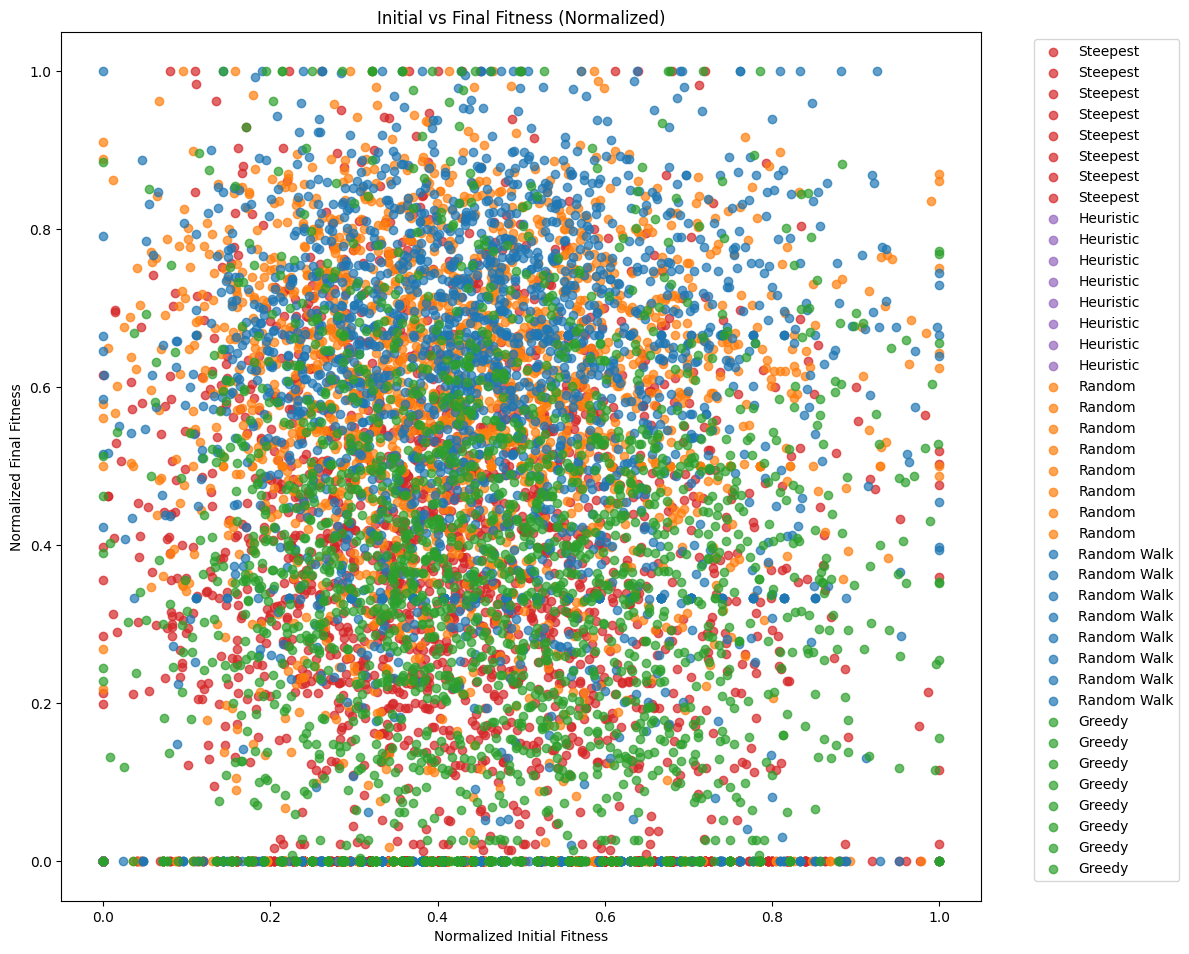